## Applications to real data sets

In [1]:
# binary classification using SGHMC

In [2]:
# libraries
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# load iris dataset
iris = datasets.load_iris()
idx = iris.target != 2
X = iris.data[idx].astype(np.float32)
y = iris.target[idx].astype(np.float32)

In [4]:
# split into the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Confirm the features in the dataset
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

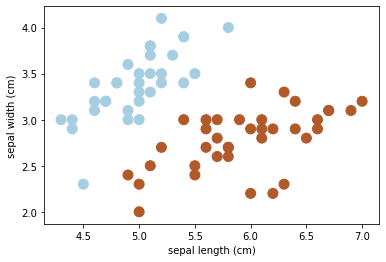

In [6]:
# plot the classes using the first two features (in 2D plot)
plt.scatter(X_train[:,0], X_train[:, 1], c=y_train,
cmap=plt.cm.Paired, s=100)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
pass

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


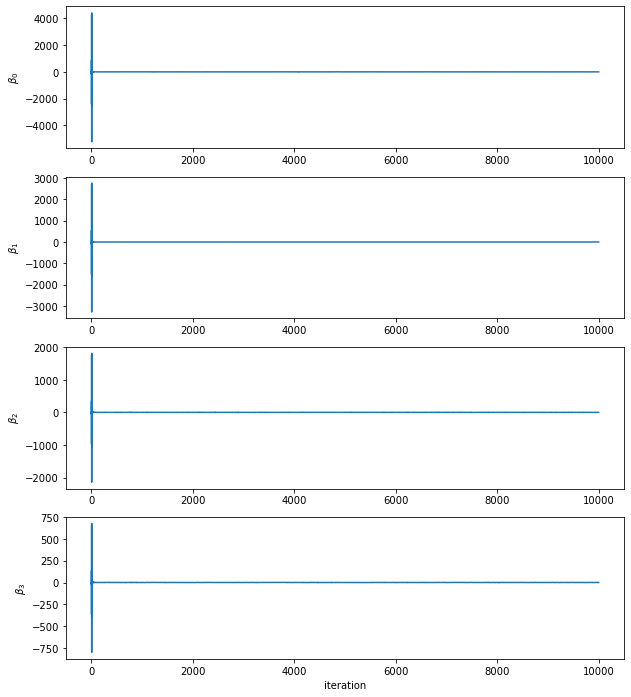

In [7]:
# Stochastic Gradient Hamiltonian Monte Carlo
def logistic_function(x):
    """Logistic function"""
    return 1 / (1 + np.exp(-x))

def LR_SGHMC(X,y):
    nstep = int(1e4);

    # Data size and feature dimention
    N, D = X.shape;
    # Set minibatch size = sqrt(N)
    tau = int(np.floor(np.sqrt(N)));


    # Initial parameter distribution
    theta = np.zeros(D);
    sigma = 0.1;
    SigmaStar = np.eye(D)*sigma;
    invSigmaStar = np.linalg.inv(SigmaStar);

    # Initialize the coefficients vector
    beta0 = np.random.rand(D);
    betaVec = np.zeros((nstep,D));
    betaVec[0,:] = beta0;

    epsilon = np.zeros(nstep);
    z = np.zeros((nstep,D));

    epsilon0 = 0.01;

    # SGHMC
    for t in range(nstep-1):
        # random sample a minibatch
        S = np.random.choice(N, tau, replace=False);

        # parameters of sghmc
        C = np.eye(D)
        Bh = 0
        
        # decay the epsilon
        epsilon[t] = max(1/(t+1), epsilon0);
        zCov = epsilon[t] * 2 * (C - Bh);
        z[t,:] = np.random.multivariate_normal(np.zeros(D),zCov);
        
        gradR = np.dot(invSigmaStar,(betaVec[t,:]-theta));
        gradL = -np.dot(X[S,:].T,(y[S]-logistic_function(np.dot(X[S,:],betaVec[t,:]))));

        betaVec[t+1,:] = betaVec[t,:]-epsilon[t]*(gradR+N/tau*gradL) - epsilon[t]*np.dot(C,betaVec[t,:]) + z[t,:];

    # plot the convergence of each coefficient
    fig = plt.figure(figsize=(10, 12));
    ax1 = fig.add_subplot(411)
    ax1.set_ylabel(r"$\beta_0$")
    ax1.plot(range(nstep),betaVec[:,0]);
    ax2 = fig.add_subplot(412)
    ax2.set_ylabel(r"$\beta_1$")
    ax2.plot(range(nstep),betaVec[:,1]);
    ax3 = fig.add_subplot(413)
    ax3.set_ylabel(r"$\beta_2$")
    ax3.plot(range(nstep),betaVec[:,2]);
    ax4 = fig.add_subplot(414)
    ax4.set_ylabel(r"$\beta_3$")
    ax4.plot(range(nstep),betaVec[:,3]);
    plt.xlabel("iteration")
    

    burn_from = int(0.9*nstep);
    samples = betaVec[burn_from+1:,:];
    return samples

samples_SGHMC = LR_SGHMC(X,y)

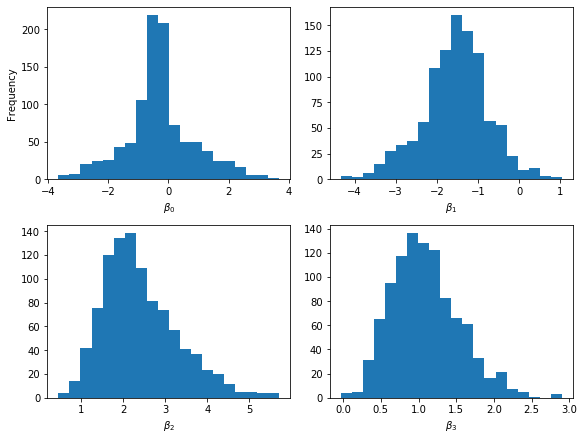

In [22]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(8, 6))
f1_axes[0, 0].hist(samples_SGHMC[:,0],20)
f1_axes[0, 0].set_ylabel("Frequency")
f1_axes[0, 0].set_xlabel(r"$\beta_0$")
f1_axes[0, 1].hist(samples_SGHMC[:,1],20)
f1_axes[0, 1].set_xlabel(r"$\beta_1$")
f1_axes[1, 0].hist(samples_SGHMC[:,2],20)
f1_axes[1, 0].set_xlabel(r"$\beta_2$")
f1_axes[1, 1].hist(samples_SGHMC[:,3],20)
f1_axes[1, 1].set_xlabel(r"$\beta_3$")
pass

In [9]:
# Test accuracy
prob_test = np.mean(logistic_function(X_test @ samples_SGHMC.T), 1)
y_hat_test = prob_test > 0.5

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_hat_test)

1.0